``Start modelling on metadata again. No imgs only metadata.``

```find correlation with lb and reach 0.75s```


# Load data and dependencies

In [124]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from joblib import Parallel, delayed

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, minmax_scale
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

In [64]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

# Utils

In [65]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [66]:
def dens_to_sev(x: float)-> int:
    """takes in density value in cells/ml and returns severity category"""
    if (x < 20_000) : return 1
    elif (x >= 20_000) and (x < 100_000) : return 2
    elif (x >= 100_000) and (x < 1_000_000) : return 3
    elif (x >= 1_000_000) and (x < 10_000_000) : return 4
    elif x > 10_000_000 : return 5

In [67]:
def region_wise_peformance(y_data=None, preds=None):
    """
    returns classifcation report for each region
    y_data : pd.DataFrame
    preds : np.array
    
    """
    y_data = y_data.copy(deep=True)
    y_data['preds'] = preds
    for region in sorted(y_data.region.unique()):
        print(region)
        print(classification_report(y_data[y_data.region == region].severity, y_data[y_data.region == region].preds))
        print()
    

In [68]:
#  Utils
def get_data_by_date( date=None, data=None):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def analyize_matches(y_true, y_pred, plot=False):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))
    
    stupid_vals = []
    for i in range(1, 6):
        stupid_vals.append(
            ((sum([1 for x, y in zip(y_true, y_pred) if x == i and y == i])/len(y_true))*100, (sum(y_true == i)/len(y_true))*100)
            )

    print()
    for i in range(5):
        print(f"Severity {i+1} : accuracy: {np.round(stupid_vals[i][0], 3)} % - prevalence: {np.round(stupid_vals[i][1], 3)} %")

    print()
    print("Classification report:")
    print(classification_report(y_true, y_pred))
    
    if plot:
        print()
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds')

# Add date fts

In [69]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week

seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

reg_sev_map = {
    'midwest': 2,
    'northeast': 2,
    'south' : 2,
    'west' : 4
}

reg_map = {
    'south' : 0,
    'northeast' : 1,
    'west' : 2,
    'midwest' : 3
}

metadata['season'] = metadata.month.map(seasons)

region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

data = pd.merge(metadata, region, on='uid', how='left')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


# Split

In [70]:
test_data = data[data.split == 'test']
test_data.shape, data.shape

((6510, 12), (23570, 12))

In [71]:
train_data = data[data.split == 'train']
train_data.shape, data.shape

((17060, 12), (23570, 12))

In [72]:
tr_data, val_data = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data.shape, val_data.shape

((14501, 12), (2559, 12))

In [73]:
# split data similar to test data
val_data['date_reg'] = val_data.date.astype(str) + "_" +  val_data.region
tr_data['date_reg'] = tr_data.date.astype(str) + "_" +  tr_data.region

assert (val_data.columns == tr_data.columns).all()

print(set(val_data.uid).intersection(set(tr_data.uid)))

# percentage of intersection date and regs before
print(f" % of intersection between date and regions in val and train sets before correction: {len(set(val_data.date_reg).intersection(set(tr_data.date_reg)))/val_data.date_reg.nunique()}")

datereg_to_remove = val_data.date_reg.sample(frac=0.40, random_state=123456789)
tr_data2_te_dist = tr_data[~tr_data.date_reg.isin(datereg_to_remove)]
val_data2_te_dist = val_data

print(f" % of intersection between date and regions in val and train sets after correction: {len(set(val_data2_te_dist.date_reg).intersection(set(tr_data2_te_dist.date_reg)))/val_data2_te_dist.date_reg.nunique()}")


print(f" % of intersection between dates in val and train sets: {len(set(val_data2_te_dist.date).intersection(set(tr_data2_te_dist.date)))/val_data2_te_dist.date.nunique() :<75f} ")
print(f" % of intersection between date in test and train sets: {len(set(test_data.date).intersection(set(train_data.date)))/test_data.date.nunique():<75f}" )

tr_data2_te_dist.shape, val_data2_te_dist.shape, train_data.shape, val_data.shape

set()
 % of intersection between date and regions in val and train sets before correction: 0.9328793774319066
 % of intersection between date and regions in val and train sets after correction: 0.36867704280155644
 % of intersection between dates in val and train sets: 0.656211                                                                    
 % of intersection between date in test and train sets: 0.701095                                                                   


((5617, 13), (2559, 13), (17060, 12), (2559, 13))

In [74]:
tr_data3 = tr_data.copy()
val_data3 = val_data.copy()

datereg_to_remove = tr_data3.date_reg.sample(frac=0.60, random_state=123456789)
val_data3_te_dist = val_data3[~val_data3.date_reg.isin(datereg_to_remove)]
tr_data3_te_dist = tr_data3

print("matching dateregs btw val and tr:", len(set(val_data3_te_dist.date_reg).intersection(set(tr_data3_te_dist.date_reg)))/val_data3_te_dist.date_reg.nunique())
print("matching dates btw val and tr:",len(set(val_data3_te_dist.date).intersection(set(tr_data3_te_dist.date)))/val_data3_te_dist.date.nunique())

tr_data3_te_dist.shape, val_data3_te_dist.shape

matching dateregs btw val and tr: 0.4
matching dates btw val and tr: 0.7589285714285714


((14501, 13), (131, 13))

In [75]:
#  split by time
train_data = train_data.sort_values(by='date')
train_data_ts = train_data[train_data.date < '2019-01-01']
val_data_ts = train_data[train_data.date >= '2019-01-01']

train_data_ts.shape, val_data_ts.shape

((11968, 12), (5092, 12))

In [76]:
tr_data.sort_values(by='date', inplace=True)
val_data.sort_values(by='date', inplace=True)

In [77]:
test_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
12,aair,33.042600,-117.076000,2014-11-01,test,2014,11,44,4,west,NaN,NaN
14,aajw,40.703968,-80.293050,2015-08-26,test,2015,8,35,3,northeast,NaN,NaN
15,aalr,38.972500,-94.672930,2019-08-26,test,2019,8,35,3,midwest,NaN,NaN
16,aalw,34.279000,-118.905000,2018-01-08,test,2018,1,2,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test,2019,7,28,3,northeast,NaN,NaN
23560,zzrv,36.875400,-121.561000,2019-09-17,test,2019,9,38,4,west,NaN,NaN
23563,zzsx,34.210000,-78.929389,2019-07-16,test,2019,7,29,3,south,NaN,NaN
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN


In [78]:
X_test = test_data[train_data.columns]
X_test

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
12,aair,33.042600,-117.076000,2014-11-01,test,2014,11,44,4,west,NaN,NaN
14,aajw,40.703968,-80.293050,2015-08-26,test,2015,8,35,3,northeast,NaN,NaN
15,aalr,38.972500,-94.672930,2019-08-26,test,2019,8,35,3,midwest,NaN,NaN
16,aalw,34.279000,-118.905000,2018-01-08,test,2018,1,2,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test,2019,7,28,3,northeast,NaN,NaN
23560,zzrv,36.875400,-121.561000,2019-09-17,test,2019,9,38,4,west,NaN,NaN
23563,zzsx,34.210000,-78.929389,2019-07-16,test,2019,7,29,3,south,NaN,NaN
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN


# CV

In [79]:
def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None):
    """
    train and eval util func,
    returns trained model, soft_preds, and tr, val, test rmses
    REMEMBER returns soft-preds
    """
    
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    val_rmse = rmse(y_val, np.clip(np.round(val_preds), 1, 5))
    train_rmse = rmse(y_train, np.clip(np.round(model.predict(X_train)), 1, 5))   # don't forget to clip!
    print("Train RMSE: ", train_rmse)
    print("Val RMSE:", val_rmse)
    if X_test is not None and y_test is not None:
        test_rmse = mse(y_test, np.clip(np.round(model.predict(X_test)), 1, 5), squared=False)
        print('TEST RMSE: ', test_rmse)
    else:
        test_rmse = 0
        
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, val_preds, train_rmse, val_rmse, test_rmse

In [80]:

def cv_it(model, X_train=None, y_train=None, X_test=None, y_test=None, splits=10, cv_predict=False):
    """ 
    cv in stratified kfold fashion, 
    returns train, val, test rmses, and cv preds for test and train if cv_predict=True
    remember to round preds
    And also send in "dates" to make val set similar to test set
    """
    
    skf = StratifiedKFold(n_splits=splits, random_state=12_000, shuffle=True)
    # tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    print('Using cols: ', X_train.columns.values)

    train_rmses = []
    val_rmses = []
    test_rmses = []
    cvpreds_test, cvpreds_train = None, None

    if cv_predict:
        if X_test is not None: test_shape = X_test.shape[0]
        else: test_shape = 6510
        cvpreds_test = np.zeros(shape=(test_shape, splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        print(f'----------------------------------Fold-{fold}------------------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        try:
            # make val set more similar to test set by making val_set.latlng.isin(trian_set.latlng) --> 0
            X_val_subset['latlng'] = X_val_subset.latitude.astype(str) + '_' + X_val_subset.longitude.astype(str)
            X_train_subset['latlng'] = X_train_subset.latitude.astype(str) + '_' + X_train_subset.longitude.astype(str)

            drp_idx = X_val_subset[X_val_subset.latlng.isin(X_train_subset.latlng)].index
            
            X_train_subset = pd.concat([X_train_subset, X_val_subset.loc[drp_idx]], axis=0)
            y_train_subset = pd.concat([y_train_subset, y_val_subset.loc[drp_idx]], axis=0)

            X_val_subset.drop(drp_idx, inplace=True)
            y_val_subset.drop(drp_idx, inplace=True)
            
            # make sure no latlng is in both train and val_data
            assert X_val_subset.latlng.isin(X_train_subset.latlng).sum() == 0
            
            # drop latlng
            X_val_subset.drop('latlng', axis=1, inplace=True)
            X_train_subset.drop('latlng', axis=1, inplace=True)
        except Exception as e:
            print('Error in making val set more similar to test set')
            print(e)
        
        assert X_train_subset.columns.tolist() == X_val_subset.columns.tolist()
        # assert X_train_subset.columns.tolist() == X_test.columns.tolist()

        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        print(y_val_subset.value_counts(normalize=True))
        model, val_preds, train_rmse, val_rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test
                                    )

        sns.barplot(model.feature_importances_, model.feature_names_in_)

        val_rmses.append(val_rmse)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        
        if cv_predict:
            # save predictions for ensembling
            if X_test is not None:
                cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = model.predict(X_train.iloc[val_idx])
                    
    print()
    print("Mean Train RMSE:", np.mean(train_rmses), "std:", np.std(train_rmses))
    print("Mean Val RMSE:", np.mean(val_rmses), "std:", np.std(val_rmses))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))
    
    return cvpreds_test, cvpreds_train, np.mean(train_rmses), np.mean(val_rmses), np.mean(test_rmses)

# Modelling

## KNN

In [81]:
def knn(row=None, train_data=tr_data, k=1):
    """
    row : pd.Series (row from val_data)
    train_data : pd.DataFrame (all_data)
    k : int number of nearest neighbours to consider
    
    algo:
    1. Get past month data collected till the current row
    2. Get the k nearest neighbours (geodesic dist using lat, lng) from the above data
    3. Get the mean of the severity from the above rows
    4. Return the mean of the nearest neighbours severity

    """
    
    if row is None:
        print('Row None bruv!')
        return None
    
    uid = row.uid
    date = row.date
    region = row.region
    past_date = date - pd.Timedelta(days=30)
    
    past_month_data = train_data[(train_data.date < date) & (train_data.date >= past_date)]
    past_month_data.sort_values(by='date', inplace=True)
    
    # if no past data, return the mean of the region
    if len(past_month_data) == 0:
        return reg_sev_map[region]
        
    dist_matrix =pd.DataFrame(columns=['uid', 'dist'])       # 0th col for uid, 1st col for dist
    for i, past_row in enumerate(past_month_data.itertuples()):
        dist_matrix.loc[i, 'uid'] = past_row.uid
        dist_matrix.loc[i, 'dist'] = get_distance(row.latitude, row.longitude, past_row.latitude, past_row.longitude)   # returns geodesic dist in km

    # get mean of top k nearest neighbours
    n_uids = dist_matrix.sort_values(by='dist').head(k).uid.values
    nn_severity = train_data[train_data.uid.isin(n_uids)].severity.mean()
    
    return np.round(nn_severity)


## Incremental Xgb

In [82]:
train_data.eq(train_data.sort_values(by='date')).value_counts().sum()

17060

In [83]:
drop_cols = ['date', 'uid', 'year', 'split', 'severity']
drop_cols

['date', 'uid', 'year', 'split', 'severity']

In [84]:
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


In [85]:
train_df = train_data.drop(drop_cols, axis=1)
train_df.region = train_df.region.map(reg_map)
train_df.week = train_df.week.astype('int')
train_df

,latitude,longitude,month,week,season,region,density
5317,44.850500,-93.515700,1,1,1,3,476.0
6144,44.878889,-93.490833,1,1,1,3,558.0
5566,44.877646,-93.557842,1,1,1,3,1416.0
13644,44.822478,-93.367962,1,1,1,3,1884.0
4387,44.847993,-93.476318,1,1,1,3,115.0
...,...,...,...,...,...,...,...
17778,36.030000,-78.705932,12,50,1,0,4357.0
11041,35.980000,-78.843884,12,50,1,0,34492.0
6718,36.030000,-78.706429,12,50,1,0,31769.0
18793,35.980000,-78.843636,12,50,1,0,20021.0


In [86]:
xgb_params = {
    'n_estimators': 50,   # intially
    'max_depth': 5,
    # 'learning_rate': 0.1,
    # 'subsample': 0.8,
    # 'colsample_bytree': 0.8,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'n_jobs': -1,
    'random_state': 12_000,
    'gpu_id' : 0,
    'verbosity' : 0
}

In [87]:
100 * 250

25000

<AxesSubplot:xlabel='density', ylabel='Density'>

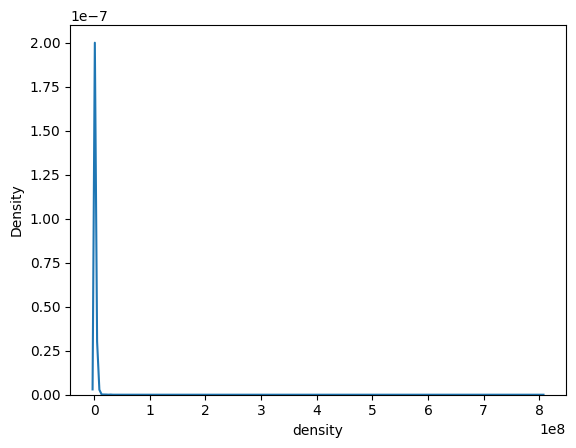

In [90]:
val_idx = train_df.sample(250, random_state=12_000).index

sns.kdeplot(train_df.density)

In [115]:
%%time

val_idx = val_idx
val_preds = []

model = None
train_batch = pd.DataFrame(columns=train_df.columns)

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    if idx not in val_idx:
        # accumulate training samples until val sample is found
        train_batch.loc[idx] = row
    else:
        model = xgb.train(
            xgb_params, 
            xgb_model=model,
            dtrain=xgb.DMatrix(train_batch.drop('density', axis=1).values, label=train_batch.density.values)
            )
        preds = model.predict(xgb.DMatrix(row.drop('density').values.reshape(1, -1)))
        val_preds.append(preds[0])
        train_batch.loc[idx] = row
        # print(f"val rmse for {idx}:", rmse([train_df.loc[idx].severity.map(dens_to_sev)], preds))


100%|██████████| 17060/17060 [02:00<00:00, 141.23it/s]

CPU times: total: 7min 4s
Wall time: 2min


In [119]:
train_data.density.max() - train_data.density.min()

804667500.0

In [166]:
# val_preds_ = minmax_scale(val_preds, (train_data.density.min(), train_data.density.max()))
# val_preds_.max(), val_preds_.min()

(804667500.0, 0.0)

In [170]:
val_preds_ = np.clip(val_preds, train_data.density.min(), train_data.density.max())
val_preds_.max(), val_preds_.min()


(69441976.0, 0.0)

<AxesSubplot:ylabel='Density'>

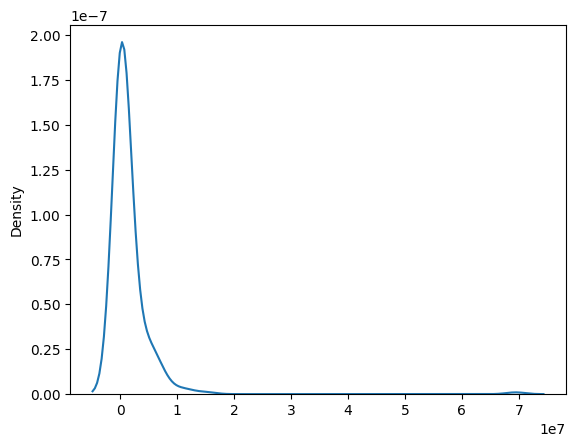

In [171]:
sns.kdeplot(val_preds_)

In [172]:
val_preds_ = np.array(list(map(dens_to_sev, val_preds_)))
val_preds_.max(), val_preds_.min(), val_preds_.mean()

(5, 1, 2.552)

In [173]:
val_preds_

array([4, 1, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 2, 4, 4, 4,
       1, 4, 1, 4, 1, 4, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 4, 3, 1, 4, 4,
       4, 1, 4, 3, 3, 4, 4, 1, 1, 3, 4, 3, 1, 1, 1, 4, 1, 3, 2, 3, 3, 2,
       2, 3, 3, 3, 1, 1, 4, 1, 3, 3, 1, 1, 1, 3, 2, 1, 1, 2, 3, 4, 4, 4,
       4, 3, 1, 2, 4, 4, 1, 1, 1, 4, 3, 1, 1, 3, 4, 1, 4, 3, 1, 3, 3, 1,
       2, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 4, 2, 4, 3, 3, 3, 3, 5, 4, 5, 4,
       4, 1, 3, 3, 1, 3, 3, 5, 3, 1, 1, 1, 4, 3, 3, 2, 1, 4, 1, 3, 3, 3,
       4, 4, 3, 3, 1, 1, 3, 3, 2, 3, 3, 3, 1, 1, 3, 1, 1, 4, 3, 1, 3, 4,
       1, 4, 3, 1, 1, 3, 1, 4, 3, 4, 3, 3, 2, 2, 4, 1, 3, 4, 1, 2, 3, 3,
       1, 4, 3, 1, 1, 3, 1, 4, 4, 1, 4, 4, 4, 4, 1, 1, 1, 4, 3, 3, 3, 4,
       1, 5, 4, 2, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 3, 2, 3, 3, 4, 4, 5,
       3, 3, 1, 3, 1, 4, 4, 1])

In [174]:
print("Val RMSE:", rmse(train_df.loc[val_idx].density.map(dens_to_sev), val_preds_))

Val RMSE: 1.7492855684535902


In [175]:
train_data.density.max()

804667500.0

In [176]:
analyize_matches(train_df.loc[val_idx].density.map(dens_to_sev), val_preds_)
# worst than all 1s :(

Exact matches:  0.3
Missed by 1:  0.232
Missed by 2:  0.288
Missed by 3:  0.172
Missed by 4:  0.008

Severity 1 : accuracy: 17.2 % - prevalence: 46.0 %
Severity 2 : accuracy: 1.2 % - prevalence: 16.8 %
Severity 3 : accuracy: 7.2 % - prevalence: 18.8 %
Severity 4 : accuracy: 4.4 % - prevalence: 18.0 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.4 %

Classification report:
              precision    recall  f1-score   support

           1       0.52      0.37      0.43       115
           2       0.15      0.07      0.10        42
           3       0.23      0.38      0.29        47
           4       0.17      0.24      0.20        45
           5       0.00      0.00      0.00         1

    accuracy                           0.30       250
   macro avg       0.21      0.21      0.20       250
weighted avg       0.34      0.30      0.31       250

